# Raw data correlation

Since the goal of any data preprocessing is to minimize contributions from unwanted sources of variation maximizing the *true* biological signals in order to make them comparable, it is reasonable to consider a simple correlation with the original biological information (raw data) a measure for how much of the original biological information have been retained after the normalization process.

Here the file `expdata_ecoli_raw_data.h5` is an HDF5 that contains a matrix with all the raw data directly taken from GEO and ArrayExpress in which each column represent a single sample and each row represent a gene. Each value is either raw count in case of RNA-seq or the mean of the intensity values for microarray.

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
### Read COLOMBOS contrast data
colombos_ctr_data = pd.read_table('colombos_ecoli_exprdata_20151029.txt', sep='\t', nrows=6)
colombos_ctr_data = colombos_ctr_data[colombos_ctr_data.columns[2:]]
colombos_ctr_data = colombos_ctr_data.set_index(colombos_ctr_data.columns[0])
colombos_ctr_data.index = list(colombos_ctr_data.index[:-1]) + ['Contrast ID']

### Read COLOMBOS gene data
colombos_gene_data = pd.read_table('colombos_ecoli_exprdata_20151029.txt', sep='\t', skiprows=6)
colombos_gene_data = colombos_gene_data[colombos_gene_data.columns[:3]]
colombos_gene_data.columns = list(colombos_gene_data.columns[:2]) + ['Gene ID']
colombos_gene_data = colombos_gene_data.set_index('Gene ID')
colombos_gene_data['LocusTag'] = ['m.' + lc for lc in colombos_gene_data['LocusTag'].tolist()]

### Read COLOMBOS expression data
colombos_exp_data = pd.read_table('colombos_ecoli_exprdata_20151029.txt', sep='\t', skiprows=6)
colombos_exp_data = colombos_exp_data[colombos_exp_data.columns[2:]]
colombos_exp_data = colombos_exp_data.rename(columns = {'Geneid/Contrast_id':'Gene ID'})
colombos_exp_data = colombos_exp_data.set_index('Gene ID')

In [3]:
store = pd.HDFStore('expdata_ecoli_raw_data.h5')
df_raw_data = store['df']
store.close()

In [4]:
ecomics_info = pd.read_csv('ncomms13090-s2_trans.csv', index_col=0)
ecomics_v8 = pd.read_csv('ecomics.transcriptome.no_avg.v8.txt', sep='\t', index_col=0)
del ecomics_v8['Cond']

In [5]:
gene_order = sorted(list(set(df_raw_data.index).intersection(ecomics_v8.columns)))

In [6]:
corr_v8_raw = []
for column in list(df_raw_data.columns):
    sample_name, ch = column.split('.ch')
    try:
        idx = ecomics_info[(ecomics_info['Sample ID'] == sample_name)&(ecomics_info['Ch'] == ch)].index[0]
        corr = pd.DataFrame({'ecomics_v8' : ecomics_v8[gene_order].loc[idx],
                    'raw': np.log2(df_raw_data[column].loc[gene_order])})
        corr_v8_raw.append(corr.corr().as_matrix()[0,1])
    except Exception as e:
        pass

In [7]:
colombos_raw = []
gene_order_ids = colombos_gene_data.reset_index().set_index('LocusTag').loc[gene_order]['Gene ID'].tolist()
for ctr in colombos_ctr_data.columns:
    ctr_id = colombos_ctr_data[ctr]['Contrast ID']
    try:
        test, ref= ctr.split('-vs-')
        corr = pd.DataFrame({'colombos' : colombos_exp_data[ctr_id].loc[gene_order_ids].values,
                            'raw': (np.log2(df_raw_data[test].loc[gene_order]) - 
                             np.log2(df_raw_data[ref].loc[gene_order])).values}, index=gene_order)
        colombos_raw.append(corr.corr().as_matrix()[0,1])
    except Exception as e:
        pass

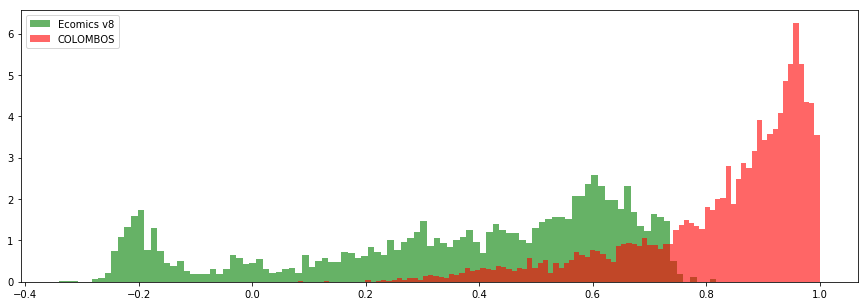

In [9]:
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sea

%matplotlib inline

plt.figure(figsize=(15,5))

corr_v8_raw = np.array(corr_v8_raw)
corr_v8_raw = corr_v8_raw[~np.isnan(corr_v8_raw)]

colombos_raw = np.array(colombos_raw)
colombos_raw = colombos_raw[~np.isnan(colombos_raw)]
                          
_ = plt.hist(corr_v8_raw, bins=100, color='green', alpha=0.6, normed=True, label='Ecomics v8')
_ = plt.hist(colombos_raw, bins=100, color='red', alpha=0.6, normed=True, label='COLOMBOS')
plt.legend(loc='best')
plt.show()